### Modeling and visualizing dynamics of COVID cases in Maryland counties
#### Anna Konstorum (konstorum.anna@gmail.com)

In [1]:
# import packages
import datetime
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
print(f'Last updated: {datetime.date.today()}')

Last updated: 2020-04-17


In [3]:
# import latest MD county counts
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_county_covid.csv'
md_county=pd.read_csv(url,sep=',',header='infer', parse_dates=[1],index_col=0)
md_p_today=md_county.iloc[-1]
md_p_today=md_p_today[0:-1]

In [38]:
# import additional data

# hospitalization and deaths counts for Maryland
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_covid_H.csv'
md_xtra=pd.read_csv(url,sep=',',header='infer', parse_dates=[1],index_col=0)

# deaths counts for all counties
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_covid_D.csv'
md_d=pd.read_csv(url,sep=',',header='infer', parse_dates=[1],index_col=0)
md_d_today=md_d.iloc[-1]
md_d_today=md_d_today.iloc[0:-2]

# maryland population demographics
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_2019_pop.csv'
md_pop=pd.read_csv(url,sep=',',header='infer',index_col=0)

In [5]:
md_county.tail()

,Date,Allegany,Anne Arundel,Baltimore City,Baltimore County,Calvert,Caroline,Carroll,Cecil,Charles,...,Montgomery,Prince Georges,Queen Anne's,St. Mary's,Somerset,Talbot,Washington,Wicomico,Worcester,Total
Date_index,,,,,,,,,,,,,,,,,,,,,
38,2020-04-12,13,659,812,1257,90,17,236,74,253,...,1631,2035,19,82,4,14,75,42,20,8225
39,2020-04-13,15,724,873,1361,94,21,250,83,274,...,1756,2205,19,95,6,16,93,58,21,8936
40,2020-04-14,17,783,962,1377,99,21,259,85,292,...,1883,2356,19,98,5,16,96,63,21,9472
41,2020-04-15,17,845,1060,1485,102,22,262,90,310,...,1933,2516,19,99,5,14,106,76,22,10032
42,2020-04-16,20,896,1160,1516,103,23,283,101,327,...,2133,2722,19,98,6,14,109,87,25,10784


In [6]:
# create exponential function to model 
# will add additional functions shortly

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def quad_func(x,a,b,c):
    return a*x**2 +b*x+c

def lin_func(x,a,b):
    return a*x + b

In [7]:
def SSE_curve(x,y,fxn):
    popt,pop = curve_fit(fxn,x,y)
    y_exp= fxn(x, *popt)
    SSE = sum((y-y_exp)**2)
    return popt,SSE

In [8]:
# date range of the graph
start_date = min(md_county['Date'])
end_date = max(md_county['Date'])
next_date=end_date+datetime.timedelta(days=1)

print(f'Data from {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')

Data from 2020-03-05 to 2020-04-16


In [9]:
# Textual date for labels
tomorrow_label = (end_date + datetime.timedelta(days=1)).strftime('%m/%d')
next2_label = (end_date + datetime.timedelta(days=2)).strftime('%m/%d')
next3_label = (end_date + datetime.timedelta(days=3)).strftime('%m/%d')

# get current date range
date_range=pd.date_range(start=start_date, end=end_date)
date_range_plus=pd.date_range(start=start_date,end=next_date)


# output date range as list
dates = [date.strftime('%m/%d') for date in date_range_plus]

In [10]:
# Include all dates, even those with missing data
xdata_full=np.array(range(len(dates)))
xdata_pred=np.array(range(len(dates)))[-11:]
xdata_hosp=np.array(range(len(dates)))[-11:]

In [11]:
# model fit for hosp
model_hosp = pd.DataFrame(index=['hosp'],columns=['a','b','c','model'])
model_hosp.fillna(0)

xdata=np.array(md_xtra.index)[17:]
ydata=np.array(md_xtra["Hospitalized"])[17:]

popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)

quad_lin_diff=(SSE_lin-SSE_quad)/SSE_lin*100
    
if quad_lin_diff<5:
    no_quad=1
else:
    no_quad=0
    
try:
    popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
    min_error=min(SSE_exp,SSE_quad,SSE_lin)
except:    
    min_error=min(SSE_quad,SSE_lin)

if (min_error==SSE_quad) and (no_quad==1):
    min_error=SSE_lin
    
if min_error == SSE_exp:
    model_hosp.loc['hosp',['a','b','c']]=popt_exp
    model_hosp.loc['hosp','model']='exp'
elif min_error == SSE_quad:
    model_hosp.loc['hosp',['a','b','c']]=popt_quad
    model_hosp.loc['hosp','model']='quad'
elif min_error == SSE_lin:
    model_hosp.loc['hosp',['a','b']]=popt_lin
    model_hosp.loc['hosp','model']='lin'

In [12]:
model_hosp

,a,b,c,model
hosp,3.0259,-79.8115,462.498,quad


In [13]:
# model fit for select counties
import math

counties_to_model=['Montgomery','Anne Arundel',"Prince Georges","Howard",'Baltimore City','Baltimore County','Total']
model_results=pd.DataFrame(index=counties_to_model,columns=['a','b','c','model'])
model_results.fillna(0)

xdata=np.array(md_county.index)[-10:]
for county in counties_to_model:
    ydata=np.array(md_county[county])[-10:]
    
    popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
    popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)
    
    quad_lin_diff=((SSE_lin/SSE_quad)-1)*100
    print(county)
    print(quad_lin_diff)
    
    if quad_lin_diff<5:
        no_quad=1
    else:
        no_quad=0
    
    try:
        popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
        min_error=min(SSE_exp,SSE_quad,SSE_lin)
    except:    
        min_error=min(SSE_quad,SSE_lin)
    
    if (min_error==SSE_quad) and (no_quad==1):
        min_error=SSE_lin

    if min_error == SSE_quad:
        model_results.loc[county,['a','b','c']]=popt_quad
        model_results.loc[county,'model']='quad'
    elif min_error == SSE_lin:
        model_results.loc[county,['a','b']]=popt_lin
        model_results.loc[county,'model']='lin'
    elif min_error == SSE_exp:
        model_results.loc[county,['a','b','c']]=popt_exp
        model_results.loc[county,'model']='exp'

Montgomery
124.684302801
Anne Arundel
-5.55111512313e-14
Prince Georges
133.693994846
Howard
130.144327748
Baltimore City
39.9062662732
Baltimore County
407.271557858
Total
185.559665086


/Users/annakonstorum/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [14]:
model_results

,a,b,c,model
Montgomery,-4.29924,454.661,-9425.12,quad
Anne Arundel,56.5515,-1478.98,NaN,lin
Prince Georges,-5.01136,556.089,-11836.9,quad
Howard,-0.708333,75.7068,-1485.67,quad
Baltimore City,1.58333,-46.2652,293.318,quad
Baltimore County,-6.30682,564.223,-11063.6,quad
Total,-18.9129,2097.91,-44099.7,quad


In [15]:
#func use
def function_use(county,model_results):
    if model_results.loc[county]["model"]=='exp':
        func_use=exp_func
        opt_model = 'Exponential'
    elif model_results.loc[county]["model"]=='quad':
        func_use=quad_func
        opt_model = 'Quadratic (up)'
        if model_results.loc[county]['a']<0:
            opt_model = "Quadratic (down)"
    else:
        func_use=lin_func
        opt_model = 'Linear'
    return func_use, opt_model

In [16]:
# hospitalization/positive case ratio
h_p=pd.DataFrame(md_xtra.loc[21:]["Hospitalized"]/md_county.loc[21:]["Total"])
h_p.columns=["Percent"]
h_p["Percent"] = [float("{:.3f}".format(100*item)) for item in h_p["Percent"]]
h_p[-4:-1]

,Percent
Date_index,
39,22.102
40,22.403
41,22.239


In [17]:
# hospitalization/positive case ratio
h_d=pd.DataFrame(md_xtra.loc[23:]["Deaths"]/md_county.loc[23:]["Total"])
h_d.columns=["Percent"]
h_d["Percent"] = [float("{:.3f}".format(100*item)) for item in h_d["Percent"]]
h_d[-4:-1]
h_d.iloc[-1]["Percent"]

3.6349999999999998

### Maryland model and dynamics

In [18]:
next_day = xdata_pred[-1]
next2_day = next_day+1; next3_day = next_day+2
sub = "[1] First cases in Maryland; [2] Bars, restaurants, gyms close; [3] Non-essential businesses close; [4] Stay-at-home order"

In [19]:
popt_state = model_results.loc["Total"][0:3]
func_use, opt_model = function_use("Total",model_results)

popt_hosp = model_hosp.loc["hosp"][0:3]
func_use_hosp, opt_model_hosp = function_use("hosp",model_hosp)

if opt_model=="Linear":
    next_day_cases = func_use(next_day, popt_state[0], popt_state[1])
    next2_day_cases = func_use(next2_day, popt_state[0], popt_state[1])
    next3_day_cases = func_use(next3_day, popt_state[0], popt_state[1])

else:    
    next_day_cases = func_use(next_day, popt_state[0], popt_state[1], popt_state[2])
    next2_day_cases = func_use(next2_day, popt_state[0], popt_state[1], popt_state[2])
    next3_day_cases = func_use(next3_day, popt_state[0], popt_state[1], popt_state[2])

if opt_model_hosp=="Linear":
    next_day_cases_hosp = func_use_hosp(next_day, popt_hosp[0], popt_hosp[1])
    next2_day_cases_hosp = func_use_hosp(next2_day, popt_hosp[0], popt_hosp[1])
    next3_day_cases_hosp = func_use_hosp(next3_day, popt_hosp[0], popt_hosp[1])

else:
    next_day_cases_hosp = func_use_hosp(next_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])
    next2_day_cases_hosp = func_use_hosp(next2_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])
    next3_day_cases_hosp = func_use_hosp(next3_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])


loc = "Maryland cases"
locH = "Maryland hospitalizations"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


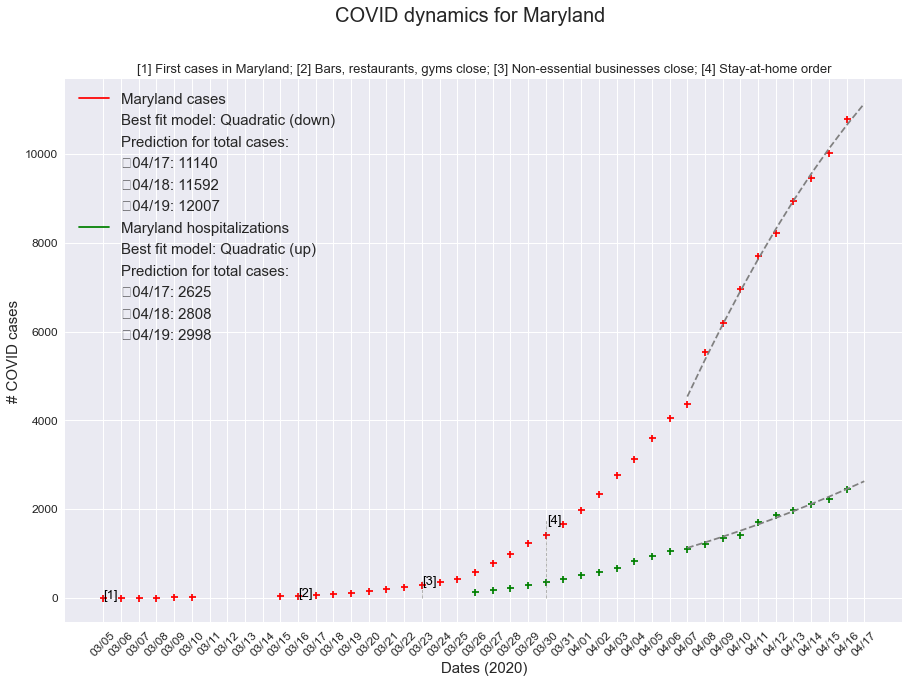

In [20]:
legend_elements =  [Line2D([0], [0], marker='+', color='red', label=loc, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_model), markersize=15),
                Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                   Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_cases)), markersize=1),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_cases)), markersize=15),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_cases)), markersize=15),
                    Line2D([0], [0], marker='+', color='green', label=locH, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_model_hosp), markersize=15),
                Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                   Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_cases_hosp)), markersize=1),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_cases_hosp)), markersize=15),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_cases_hosp)), markersize=15)]

plt.figure(figsize=(15,10))

if opt_model=='Linear':
    popt_state=popt_state[0:2]
if opt_model_hosp=="Linear":
    popt_hosp=popt_hosp[0:2]
    
plt.plot(xdata_pred, func_use(xdata_pred, *popt_state), color='grey',linestyle='--');
plt.scatter(md_county.index,md_county['Total'],color='red',marker='+');

plt.plot(xdata_hosp, func_use_hosp(xdata_hosp, *popt_hosp), color='grey',linestyle='--');
plt.scatter(md_xtra.index[17:],md_xtra['Hospitalized'][17:],color='green',marker='+');

plt.vlines(x=0, ymin=0, ymax=50,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,40,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=100,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,90,"[2]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=370,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,360,"[3]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=1750,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.5,1740,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for Maryland",fontsize=20);
plt.title(sub, fontsize=13);

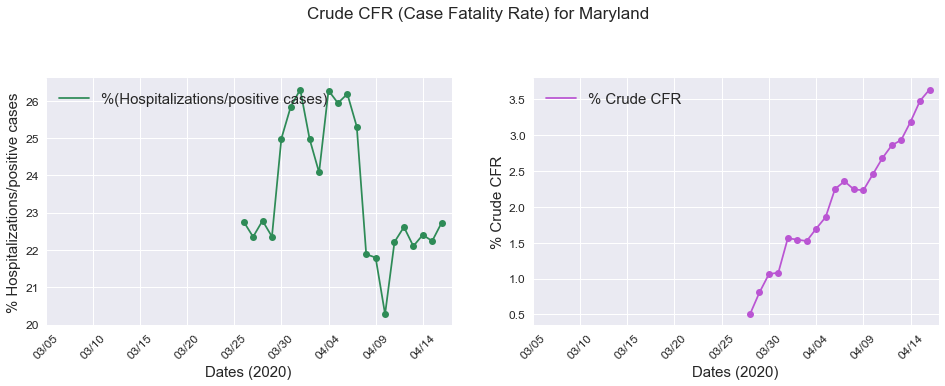

In [21]:
fig = plt.figure(figsize=(16,10))
fig.suptitle('Crude CFR (Case Fatality Rate) for Maryland',fontsize=17)

ax = fig.add_subplot(221)
legend_elements =  [Line2D([0], [0], marker='+', color='seagreen', label="%(Hospitalizations/positive cases)", markersize=15)]
plt.plot(h_p.index,h_p["Percent"],'o-',color='seagreen');  
plt.ylabel('% Hospitalizations/positive cases',fontsize=15);
frequency=5
plt.xticks(xdata_full[:-1:frequency], dates[:-1:frequency], rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')

ax = fig.add_subplot(222)
legend_elements =  [Line2D([0], [0], marker='+', color='mediumorchid', label="% Crude CFR", markersize=15)]
plt.plot(h_d.index,h_d["Percent"],'o-',color='mediumorchid');   
plt.ylabel('% Crude CFR',fontsize=15);
frequency=5
plt.xticks(xdata_full[:-1:frequency], dates[:-1:frequency], rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')

plt.show()
        

In [22]:
md_p_d=pd.DataFrame(index=md_d_today.index[1:],columns=['CFR'])
for county in md_d_today.index[1:]:
    c_d=md_d_today.loc[county]
    c_p=md_p_today.loc[county]
    if (c_d>1) or (c_p>20):
        p_d=md_d_today.loc[county]/md_p_today.loc[county]*100
        md_p_d.loc[county,'CFR']=p_d
    else:
        md_p_d.loc[county,'CFR']=-1
md_p_d.sort_values(by="CFR",inplace=True)
md_p_d = md_p_d[md_p_d["CFR"]>=0]

Text(0.5, 1.0, 'Current Crude CFR (case fatality rate) for Maryland counties')

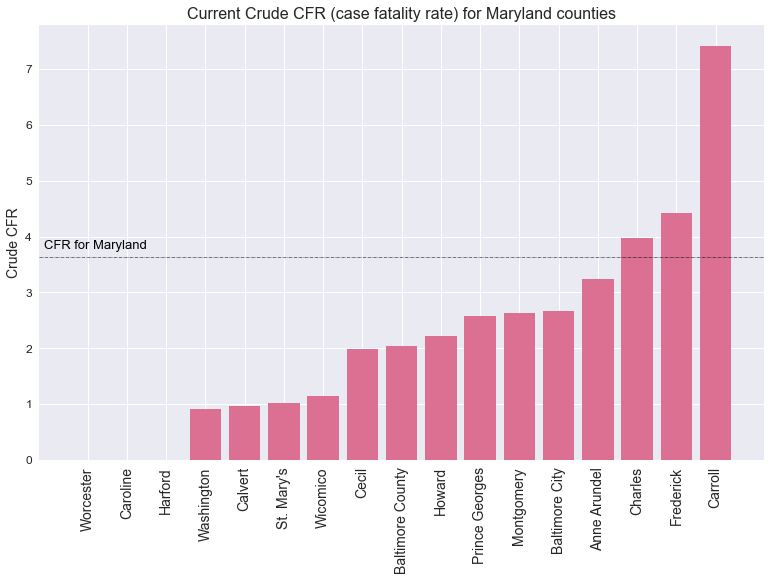

In [57]:
cfr_county=md_p_d["CFR"].values
plt.figure(figsize=(13,8));
plt.bar(range(md_p_d.shape[0]),cfr_county,color='palevioletred')
plt.ylabel("Crude CFR",fontsize=14)
plt.yticks(fontsize=12)
plt.axhline(y=h_d.iloc[-1]["Percent"],color='black', linewidth=0.5,linestyle='-.');
plt.text(0.2,h_d.iloc[-1]["Percent"]+0.2,"CFR for Maryland",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center')
plt.xticks(range(md_p_d.shape[0]),md_p_d.index, rotation=90,fontsize=14);
plt.title("Current Crude CFR (case fatality rate) for Maryland counties",fontsize=16)

In [44]:
md_p_today=md_county.iloc[-1]
md_p_pop=pd.DataFrame(index=md_pop.index[0:-6],columns=["positive","pop","fraction"])
for county in md_pop.index[0:-6]:
    county_p = md_p_today.loc[county]
    county_pop=md_pop.loc[county]["Population_2019"]
    md_p_pop.loc[county]["positive"]=county_p
    md_p_pop.loc[county,"pop"]=county_pop
    md_p_pop.loc[county,"fraction"] = round(county_p/county_pop*100,4)

In [54]:
md_p_pop

,positive,pop,fraction
Attribute,,,
Allegany,20,70416,0.0284
Anne Arundel,896,579234,0.1547
Baltimore City,1160,593490,0.1955
Baltimore County,1516,827370,0.1832
Calvert,103,92525,0.1113
Caroline,23,33406,0.0688
Carroll,283,168447,0.168
Cecil,101,102855,0.0982
Charles,327,163257,0.2003


/Users/annakonstorum/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Positive population % for Maryland counties')

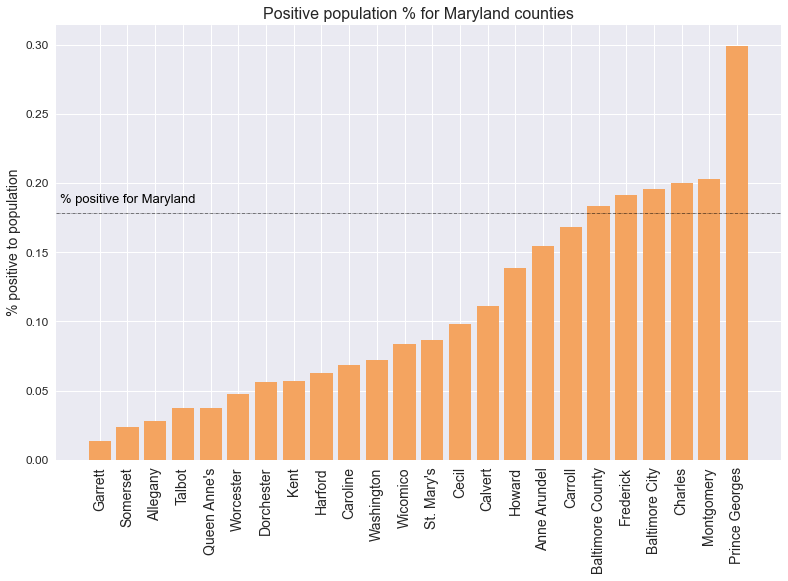

In [55]:
county_frac=md_p_pop.iloc[0:-1]
county_frac.sort_values(by="fraction",inplace=True)
frac_county=county_frac["fraction"].values
plt.figure(figsize=(13,8));
plt.bar(range(county_frac.shape[0]),frac_county,color='sandybrown')
plt.ylabel("% positive to population",fontsize=14)
plt.yticks(fontsize=12)
plt.axhline(y=md_p_pop.loc["Total"]["fraction"],color='black', linewidth=0.5,linestyle='-.');
plt.text(1,md_p_pop.loc["Total"]["fraction"]+0.01,"% positive for Maryland",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center')
plt.xticks(range(county_frac.shape[0]),county_frac.index, rotation=90,fontsize=14);
plt.title("Positive population % for Maryland counties",fontsize=16)

### Dynamics for two counties: Montgomery and Prince George's

In [ ]:
poptM = model_results.loc["Montgomery"][0:3]
poptP = model_results.loc["Prince Georges"][0:3]

func_useM, opt_modelM = function_use("Montgomery",model_results)
func_useP, opt_modelP = function_use("Prince Georges",model_results)

if opt_modelM=="Linear":
    next_day_casesM = func_useM(next_day, poptM[0], poptM[1])
    next2_day_casesM = func_useM(next2_day, poptM[0], poptM[1])
    next3_day_casesM = func_useM(next3_day, poptM[0], poptM[1])

else:    
    next_day_casesM = func_useM(next_day, poptM[0], poptM[1], poptM[2])
    next2_day_casesM = func_useM(next2_day, poptM[0], poptM[1], poptM[2])
    next3_day_casesM = func_useM(next3_day, poptM[0], poptM[1], poptM[2])


if opt_modelP=="Linear":
    next_day_casesP = func_useP(next_day, poptP[0], poptP[1])
    next2_day_casesP = func_useP(next2_day, poptP[0], poptP[1])
    next3_day_casesP = func_useP(next3_day, poptP[0], poptP[1])

else:
    next_day_casesP = func_useP(next_day, poptP[0], poptP[1], poptP[2])
    next2_day_casesP = func_useP(next2_day, poptP[0], poptP[1], poptP[2])
    next3_day_casesP = func_useP(next3_day, poptP[0], poptP[1], poptP[2])

locM = "Montgomery County"
locP = "Prince George's County"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

In [ ]:
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='maroon', label=locM, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelM), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesM)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesM)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesM)), markersize=15),
                    Line2D([0], [0], marker='+', color='orange', label=locP, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelP), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesP)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesP)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesP)), markersize=15)]

plt.figure(figsize=(15,10));

if opt_modelM=='Linear':
    poptM=poptM[0:2]
if opt_modelP=="Linear":
    poptP=poptP[0:2]

plt.plot(xdata_pred, func_useM(xdata_pred, *poptM), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Montgomery'],color='maroon',marker='+')

plt.plot(xdata_pred, func_useP(xdata_pred, *poptP), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Prince Georges'],color='orange',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=50,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,45,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=70,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,65,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=125,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,120,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=400,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.4,395,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for two Maryland counties: Montgomery and Prince George's",fontsize=20); 
plt.title(sub, fontsize=13);

### Dynamics for two counties: Howard and Anne Arundel

In [ ]:
poptH = model_results.loc["Howard"][0:3]
poptA = model_results.loc["Anne Arundel"][0:3]

func_useH, opt_modelH = function_use("Howard",model_results)
func_useA, opt_modelA = function_use("Anne Arundel",model_results)

if opt_modelH=="Linear":
    next_day_casesH = func_useH(next_day, poptH[0], poptH[1])
    next2_day_casesH = func_useH(next2_day, poptH[0], poptH[1])
    next3_day_casesH = func_useH(next3_day, poptH[0], poptH[1])
else:
    next_day_casesH = func_useH(next_day, poptH[0], poptH[1], poptH[2])
    next2_day_casesH = func_useH(next2_day, poptH[0], poptH[1], poptH[2])
    next3_day_casesH = func_useH(next3_day, poptH[0], poptH[1], poptH[2])


if opt_modelA=="Linear":
    next_day_casesA = func_useA(next_day, poptA[0], poptA[1])
    next2_day_casesA = func_useA(next2_day, poptA[0], poptA[1])
    next3_day_casesA = func_useA(next3_day, poptA[0], poptA[1])

else:
    next_day_casesA = func_useA(next_day, poptA[0], poptA[1], poptA[2])
    next2_day_casesA = func_useA(next2_day, poptA[0], poptA[1], poptA[2])
    next3_day_casesA = func_useA(next3_day, poptA[0], poptA[1], poptA[2])

locH = "Howard County"
locA = "Anne Arundel County"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

In [ ]:
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='yellow', label=locH, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelH), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesH)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesH)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesH)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label='', markersize=15),
                    Line2D([0], [0], marker='+', color='slateblue', label=locA, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelA), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesA)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesA)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesA)), markersize=15)]

if opt_modelH=='Linear':
    poptH=poptH[0:2]
if opt_modelA=="Linear":
    poptA=poptA[0:2]

plt.figure(figsize=(15,10));

plt.plot(xdata_pred, func_useH(xdata_pred, *poptH), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Howard'],color='yellow',marker='+')

plt.plot(xdata_pred, func_useA(xdata_pred, *poptA), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Anne Arundel'],color='slateblue',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,15,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,15,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=40,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,35,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=150,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.4,145,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=12);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=13)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for two Maryland counties: Howard and Anne Arundel",fontsize=20);   
plt.title(sub, fontsize=13);

In [ ]:
poptB1 = popt_state = model_results.loc["Baltimore City"][0:3]
poptB2 = popt_state = model_results.loc["Baltimore County"][0:3]

func_useB1, opt_modelB1 = function_use("Baltimore City",model_results)
func_useB2, opt_modelB2 = function_use("Baltimore County",model_results)

if opt_modelB1=="Linear":
    next_day_casesB1 = func_useB1(next_day, poptB1[0], poptB1[1])
    next2_day_casesB1 = func_useB1(next2_day, poptB1[0], poptB1[1])
    next3_day_casesB1 = func_useB1(next3_day, poptB1[0], poptB1[1])
    
else:
    next_day_casesB1 = func_useB1(next_day, poptB1[0], poptB1[1], poptB1[2])
    next2_day_casesB1 = func_useB1(next2_day, poptB1[0], poptB1[1], poptB1[2])
    next3_day_casesB1 = func_useB1(next3_day, poptB1[0], poptB1[1], poptB1[2])

if opt_modelB2=="Linear":
    next_day_casesB2 = func_useB2(next_day, poptB2[0], poptB2[1])
    next2_day_casesB2 = func_useB2(next2_day, poptB2[0], poptB2[1])
    next3_day_casesB2 = func_useB2(next3_day, poptB2[0], poptB2[1])

else:
    next_day_casesB2 = func_useB2(next_day, poptB2[0], poptB2[1], poptB2[2])
    next2_day_casesB2 = func_useB2(next2_day, poptB2[0], poptB2[1], poptB2[2])
    next3_day_casesB2 = func_useB2(next3_day, poptB2[0], poptB2[1], poptB2[2])


locB1 = "Baltimore City"
locB2 = "Baltimore County"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

In [ ]:
# BALTIMORE
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='maroon', label=locB1, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelB1), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesB1)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesB1)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesB1)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label='', markersize=15),
                    Line2D([0], [0], marker='+', color='orange', label=locB2, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelB2), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesB2)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesB2)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesB2)), markersize=15)]


plt.figure(figsize=(15,10));

if opt_modelB1=='Linear':
    poptB1=poptB1[0:2]
if opt_modelB2=="Linear":
    poptB2=poptB2[0:2]

# Plot data + model
# model

plt.plot(xdata_pred, func_useB1(xdata_pred, *poptB1), color='grey',linestyle='--')
# data
plt.scatter(md_county.index,md_county['Baltimore City'],color='maroon',marker='+')

plt.plot(xdata_pred, func_useB2(xdata_pred, *poptB2), color='grey',linestyle='--')
plt.scatter(md_county.index,md_county['Baltimore County'],color='orange',marker='+')

# extra info
plt.vlines(x=0, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(0.4,20,"[1]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=11, ymin=0, ymax=20,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(11.4,20,"[2]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=18, ymin=0, ymax=45,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(18.4,45,"[3]",rotation=0,color='black',fontsize = 14,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=25, ymin=0, ymax=225,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(25.4,220,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for Baltimore City and County",fontsize=20);
plt.title(sub, fontsize=13);
